# Quality Evaluators with the Azure AI Evaluation SDK
The following sample shows the basic way to evaluate a Generative AI application in your development environment with the Azure AI evaluation SDK.

> ✨ ***Note*** <br>
> Please check the reference document before you get started - https://learn.microsoft.com/en-us/azure/ai-studio/how-to/develop/evaluate-sdk

## 🔨 Current Support and Limitations (as of 2025-01-14) 
- Check the region support for the Azure AI Evaluation SDK. https://learn.microsoft.com/en-us/azure/ai-studio/concepts/evaluation-metrics-built-in?tabs=warning#region-support

### Region support for evaluations
| Region              | Hate and Unfairness, Sexual, Violent, Self-Harm, XPIA, ECI (Text) | Groundedness (Text) | Protected Material (Text) | Hate and Unfairness, Sexual, Violent, Self-Harm, Protected Material (Image) |
|---------------------|------------------------------------------------------------------|---------------------|----------------------------|----------------------------------------------------------------------------|
| North Central US    | no                                                               | no                  | no                         | yes                                                                        |
| East US 2           | yes                                                              | yes                 | yes                        | yes                                                                        |
| Sweden Central      | yes                                                              | yes                 | yes                        | yes                                                                        |
| US North Central    | yes                                                              | no                  | yes                        | yes                                                                        |
| France Central      | yes                                                              | yes                 | yes                        | yes                                                                        |
| Switzerland West    | yes                                                              | no                  | no                         | yes                                                                        |

### Region support for adversarial simulation
| Region            | Adversarial Simulation (Text) | Adversarial Simulation (Image) |
|-------------------|-------------------------------|---------------------------------|
| UK South          | yes                           | no                              |
| East US 2         | yes                           | yes                             |
| Sweden Central    | yes                           | yes                             |
| US North Central  | yes                           | yes                             |
| France Central    | yes                           | no                              |


## ✔️ Pricing and billing
- Effective 1/14/2025, Azure AI Safety Evaluations will no longer be free in public preview. It will be billed based on consumption as following:

| Service Name              | Safety Evaluations       | Price Per 1K Tokens (USD) |
|---------------------------|--------------------------|---------------------------|
| Azure Machine Learning    | Input pricing for 3P     | $0.02                     |
| Azure Machine Learning    | Output pricing for 3P    | $0.06                     |
| Azure Machine Learning    | Input pricing for 1P     | $0.012                    |
| Azure Machine Learning    | Output pricing for 1P    | $0.012                    |


In [1]:
import pandas as pd
import os
import json

from pprint import pprint
from azure.ai.evaluation import evaluate
from azure.ai.evaluation import RelevanceEvaluator
from azure.ai.evaluation import GroundednessEvaluator, GroundednessProEvaluator
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient


from azure.ai.evaluation import (
    RelevanceEvaluator,
    CoherenceEvaluator,
    GroundednessEvaluator,
    FluencyEvaluator,
    SimilarityEvaluator,
    F1ScoreEvaluator,
    RetrievalEvaluator
)

load_dotenv(override=True)

True

In [2]:
credential = DefaultAzureCredential()

azure_ai_project_client = AIProjectClient(
    endpoint=os.environ.get("AZURE_AI_PROJECT_ENDPOINT"),
    credential=DefaultAzureCredential()
)

model_config = {
    "azure_endpoint": os.environ.get("AZURE_OPENAI_ENDPOINT"),
    "api_key": os.environ.get("AZURE_OPENAI_API_KEY"),
    "azure_deployment": os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    "api_version": os.environ.get("AZURE_OPENAI_API_VERSION"),
    "type": "azure_openai",
}

In [3]:
query_response = dict(
    query="Which tent is the most waterproof?",
    context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

conversation_str =  """{"messages": [ { "content": "Which tent is the most waterproof?", "role": "user" }, { "content": "The Alpine Explorer Tent is the most waterproof", "role": "assistant", "context": "From the our product list the alpine explorer tent is the most waterproof. The Adventure Dining Table has higher weight." }, { "content": "How much does it cost?", "role": "user" }, { "content": "$120.", "role": "assistant", "context": "The Alpine Explorer Tent is $120."} ] }""" 
conversation = json.loads(conversation_str)

## 🧪 AI-assisted Retrieval evaluator
- Evaluates retrieval score for a given query and context or a multi-turn conversation, including reasoning.
- The retrieval measure assesses the AI system's performance in retrieving information for additional context (e.g. a RAG scenario).
- Retrieval scores range from 1 to 5, with 1 being the worst and 5 being the best.

In [4]:
# Initialzing RetrievalEvaluator
retrieval_eval = RetrievalEvaluator(model_config)
# No need to set the model_config for GroundednessProEvaluator

query_response = dict(
    query="Which tent is the most waterproof?", # optional
    context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

# query_response = dict(
#     query="어떤 텐트가 방수 기능이 있어?", # optional
#     context="알파인 익스플로러 텐트가 모든 텐트 중 가장 방수 기능이 뛰어남",
#     response="알파인 익스플로러 텐트가 방수 기능이 있습니다."
# )

# Running Groundedness Evaluator on a query and response pair
retrieval_score = retrieval_eval(
    **query_response
)
print(retrieval_score)

{'retrieval': 5.0, 'gpt_retrieval': 5.0, 'retrieval_reason': 'The context directly answers the query about which tent is the most waterproof, making it highly relevant and appropriately ranked. There are no irrelevant or extraneous details that detract from the answer.', 'retrieval_result': 'pass', 'retrieval_threshold': 3}


## 🧪 AI-assisted RelevanceEvaluator
- Relevance refers to how effectively a response addresses a question. It assesses the accuracy, completeness, and direct relevance of the response based solely on the given information.

In [5]:
relevance_eval = RelevanceEvaluator(model_config)

query_response = dict(
    query="Which tent is the most waterproof?",
    #context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

relevance_score = relevance_eval(
    **query_response
)
print(relevance_score)

# input conversation result
relevance_conv_score = relevance_eval(conversation=conversation)
print(relevance_conv_score)

{'relevance': 4.0, 'gpt_relevance': 4.0, 'relevance_reason': 'The RESPONSE accurately identifies the most waterproof tent, directly answering the QUERY without any errors or omissions. Thus, it qualifies as a complete response.', 'relevance_result': 'pass', 'relevance_threshold': 3}
{'relevance': 4.0, 'gpt_relevance': 4.0, 'relevance_threshold': 3.0, 'evaluation_per_turn': {'relevance': [4.0, 4.0], 'gpt_relevance': [4.0, 4.0], 'relevance_reason': ['The RESPONSE accurately identifies the most waterproof tent, directly addressing the QUERY without any omissions or inaccuracies.', 'The RESPONSE accurately answers the QUERY regarding cost, but it does not provide any additional context or details that could enhance the understanding of what the cost pertains to. Thus, it is a complete response but not comprehensive.'], 'relevance_result': ['pass', 'pass'], 'relevance_threshold': [3, 3]}}


## 🧪 AI-assisted CoherenceEvaluator
- Coherence refers to the logical and orderly presentation of ideas in a response, allowing the reader to easily follow and understand the writer's train of thought. A coherent answer directly addresses the question with clear connections between sentences and paragraphs, using appropriate transitions and a logical sequence of ideas.

In [6]:
coherence_eval = CoherenceEvaluator(model_config)

query_response = dict(
    query="Which tent is the most waterproof?",
    #context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

relevance_score = relevance_eval(
    **query_response
)
print(relevance_score)

relevance_conv_score = relevance_eval(conversation=conversation)
print(relevance_conv_score)

coherence_score = coherence_eval(
    **query_response
)
print(coherence_score)

# input conversation result
coherence_conv_score = coherence_eval(conversation=conversation)
print(coherence_conv_score)

{'relevance': 4.0, 'gpt_relevance': 4.0, 'relevance_reason': 'The RESPONSE directly answers the QUERY by identifying the most waterproof tent, which is relevant and complete without any inaccuracies or omissions. Thus, it deserves a high score for relevance.', 'relevance_result': 'pass', 'relevance_threshold': 3}
{'relevance': 4.0, 'gpt_relevance': 4.0, 'relevance_threshold': 3.0, 'evaluation_per_turn': {'relevance': [4.0, 4.0], 'gpt_relevance': [4.0, 4.0], 'relevance_reason': ['The RESPONSE accurately identifies the most waterproof tent, directly addressing the QUERY without any omissions or inaccuracies. Thus, it qualifies as a complete response.', 'The RESPONSE accurately answers the QUERY about cost with a specific figure, making it relevant and complete. However, it does not provide any additional context or details, which prevents it from being rated higher than a complete response.'], 'relevance_result': ['pass', 'pass'], 'relevance_threshold': [3, 3]}}
{'coherence': 4.0, 'gpt_c

## 🧪 AI-assisted FluencyEvaluator
- Fluency refers to the effectiveness and clarity of written communication, focusing on grammatical accuracy, vocabulary range, sentence complexity, coherence, and overall readability. It assesses how smoothly ideas are conveyed and how easily the text can be understood by the reader.

In [7]:
fluency_eval = FluencyEvaluator(model_config)

query_response = dict(
    #query="Which tent is the most waterproof?",
    #context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

fluency_score = fluency_eval(
    **query_response
)
print(fluency_score)

# input conversation result
fluency_conv_score = fluency_eval(conversation=conversation)
print(fluency_conv_score)

{'fluency': 2.0, 'gpt_fluency': 2.0, 'fluency_reason': 'The input Data should get a Score of 2 because it communicates a simple idea clearly but lacks complexity, variety, and has no grammatical errors. It is straightforward but does not demonstrate a higher level of fluency.', 'fluency_result': 'fail', 'fluency_threshold': 3}
{'fluency': 1.5, 'gpt_fluency': 1.5, 'fluency_threshold': 3.0, 'evaluation_per_turn': {'fluency': [2.0, 1.0], 'gpt_fluency': [2.0, 1.0], 'fluency_reason': ['The input Data should get a Score of 2 because it communicates a simple idea clearly but lacks complexity, variety, and a broader vocabulary, which are necessary for higher fluency levels.', 'The RESPONSE is a single numerical value without any context or grammatical structure, making it largely incomprehensible and fitting the criteria for "Emergent Fluency."'], 'fluency_result': ['fail', 'fail'], 'fluency_threshold': [3, 3]}}


## 🧪 AI-assisted SimilarityEvaluator
- The similarity metric is calculated by instructing a language model to follow the definition (in the description) and a set of grading rubrics, evaluate the user inputs, and output a score on a 5-point scale (higher means better quality). See the definition and grading rubrics below.
- The recommended scenario is NLP tasks with a user query. Use it when you want an objective evaluation of an AI model's performance, particularly in text generation tasks where you have access to ground truth responses. Similarity enables you to assess the generated text's semantic alignment with the desired content, helping to gauge the model's quality and accuracy.

In [8]:
similarity_eval = SimilarityEvaluator(model_config)


query_response = dict(
    query="Which tent is the most waterproof?",
    #context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof.",
    ground_truth="The Alpine Explorer tent has a rainfly waterproof rating of 2000mm"
)

similarity_score = similarity_eval(
    **query_response
)
print(similarity_score)

# input conversation Not support
# similarity_conv_score = similarity_eval(conversation=conversation)
# print(similarity_conv_score)

{'similarity': 5.0, 'gpt_similarity': 5.0, 'similarity_result': 'pass', 'similarity_threshold': 3}


## 🧪 AI-assisted Groundedness evaluator
- Prompt-based groundedness using your own model deployment to output a score and an explanation for the score is currently supported in all regions.
- Groundedness Pro evaluator leverages Azure AI Content Safety Service (AACS) via integration into the Azure AI Foundry evaluations. No deployment is required, as a back-end service will provide the models for you to output a score and reasoning. Groundedness Pro is currently supported in the East US 2 and Sweden Central regions.

In [9]:
# Initialzing Groundedness and Groundedness Pro evaluators
groundedness_eval = GroundednessEvaluator(model_config)
# No need to set the model_config for GroundednessProEvaluator

query_response = dict(
    query="Which tent is the most waterproof?", # optional
    context="The Alpine Explorer Tent is the most water-proof of all tents available.",
    response="The Alpine Explorer Tent is the most waterproof."
)

# query_response = dict(
#     query="어떤 텐트가 방수 기능이 있어?", # optional
#     context="알파인 익스플로러 텐트가 모든 텐트 중 가장 방수 기능이 뛰어남",
#     response="알파인 익스플로러 텐트가 방수 기능이 있습니다."
# )

# Running Groundedness Evaluator on a query and response pair
groundedness_score = groundedness_eval(
    **query_response
)
print(groundedness_score)

# input conversation result for the groundedness evaluator
groundedness_conv_score = groundedness_eval(conversation=conversation)
print(groundedness_conv_score)

{'groundedness': 5.0, 'gpt_groundedness': 5.0, 'groundedness_reason': 'The RESPONSE accurately and completely answers the QUERY based on the CONTEXT provided, demonstrating full groundedness. There are no irrelevant details or incorrect information present.', 'groundedness_result': 'pass', 'groundedness_threshold': 3}
{'groundedness': 5.0, 'gpt_groundedness': 5.0, 'groundedness_threshold': 3.0, 'evaluation_per_turn': {'groundedness': [5.0, 5.0], 'gpt_groundedness': [5.0, 5.0], 'groundedness_reason': ['The RESPONSE accurately and completely answers the QUERY based on the CONTEXT provided, demonstrating full groundedness. There are no irrelevant details or incorrect information present.', 'The response accurately and completely answers the query by providing the exact cost mentioned in the context, demonstrating full relevance and correctness.'], 'groundedness_result': ['pass', 'pass'], 'groundedness_threshold': [3, 3]}}


## 🚀 Run Evaluators Local

In [10]:
input_path = "data/evaluate_test_data.jsonl"
output_path = "data/local_evaluation_output.json"

# https://learn.microsoft.com/en-us/azure/ai-studio/how-to/develop/flow-evaluate-sdk
retrieval_evaluator = RetrievalEvaluator(model_config)
fluency_evaluator = FluencyEvaluator(model_config)
groundedness_evaluator = GroundednessEvaluator(model_config)
relevance_evaluator = RelevanceEvaluator(model_config)
coherence_evaluator = CoherenceEvaluator(model_config)
similarity_evaluator = SimilarityEvaluator(model_config)


column_mapping = {
    "query": "${data.query}",
    "ground_truth": "${data.ground_truth}",
    "response": "${data.response}",
    "context": "${data.context}",
}

In [11]:
import time
result = evaluate(
    evaluation_name=f"evaluation_local_{int(time.time())}",
    data=input_path,
    evaluators={
            "Retrieval": retrieval_evaluator,
            "Fluency": fluency_evaluator,
            "Groundedness": groundedness_evaluator,
            "Relevance": relevance_evaluator,
            "Coherence": coherence_evaluator,
            "Similarity": similarity_evaluator

        },
    evaluator_config={
        "retrieval": {"column_mapping": column_mapping},
        "relevance": {"column_mapping": column_mapping},
        "similarity": {"column_mapping": column_mapping},
        "groundedness": {"column_mapping": column_mapping},
        "coherence": {"column_mapping": column_mapping},
        "similarity": {"column_mapping": column_mapping},
    },
    #if you want to record the data in Azure AI Foundry add the below
    #azure_ai_project=azure_ai_project_client,
    output_path=output_path,
)

[2025-06-20 08:55:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-06-20 08:55:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-06-20 08:55:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-06-20 08:55:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-06-20 08:55:21 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_Groundedness_20250620_085521_026329, log path: /home/azureuser/.promptflow/.runs/

2025-06-20 08:55:21 +0000  491972 execution.bulk     INFO     Current thread is not main thread, skip signal handler registration in BatchEngine.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Finished 1 / 3 lines.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Average execution time for completed lines: 0.59 seconds. Estimated time for incomplete lines: 1.18 seconds.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Finished 2 / 3 lines.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Average execution time for completed lines: 0.32 seconds. Estimated time for incomplete lines: 0.32 seconds.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Finished 3 / 3 lines.
2025-06-20 08:55:22 +0000  491972 execution.bulk     INFO     Average execution time for completed lines: 0.24 seconds. Estimated time for incomplete lines: 0.0 seconds.
======= Run Summary =======

Run name: "azure_ai_evaluation_evaluators_Similarity_20250620

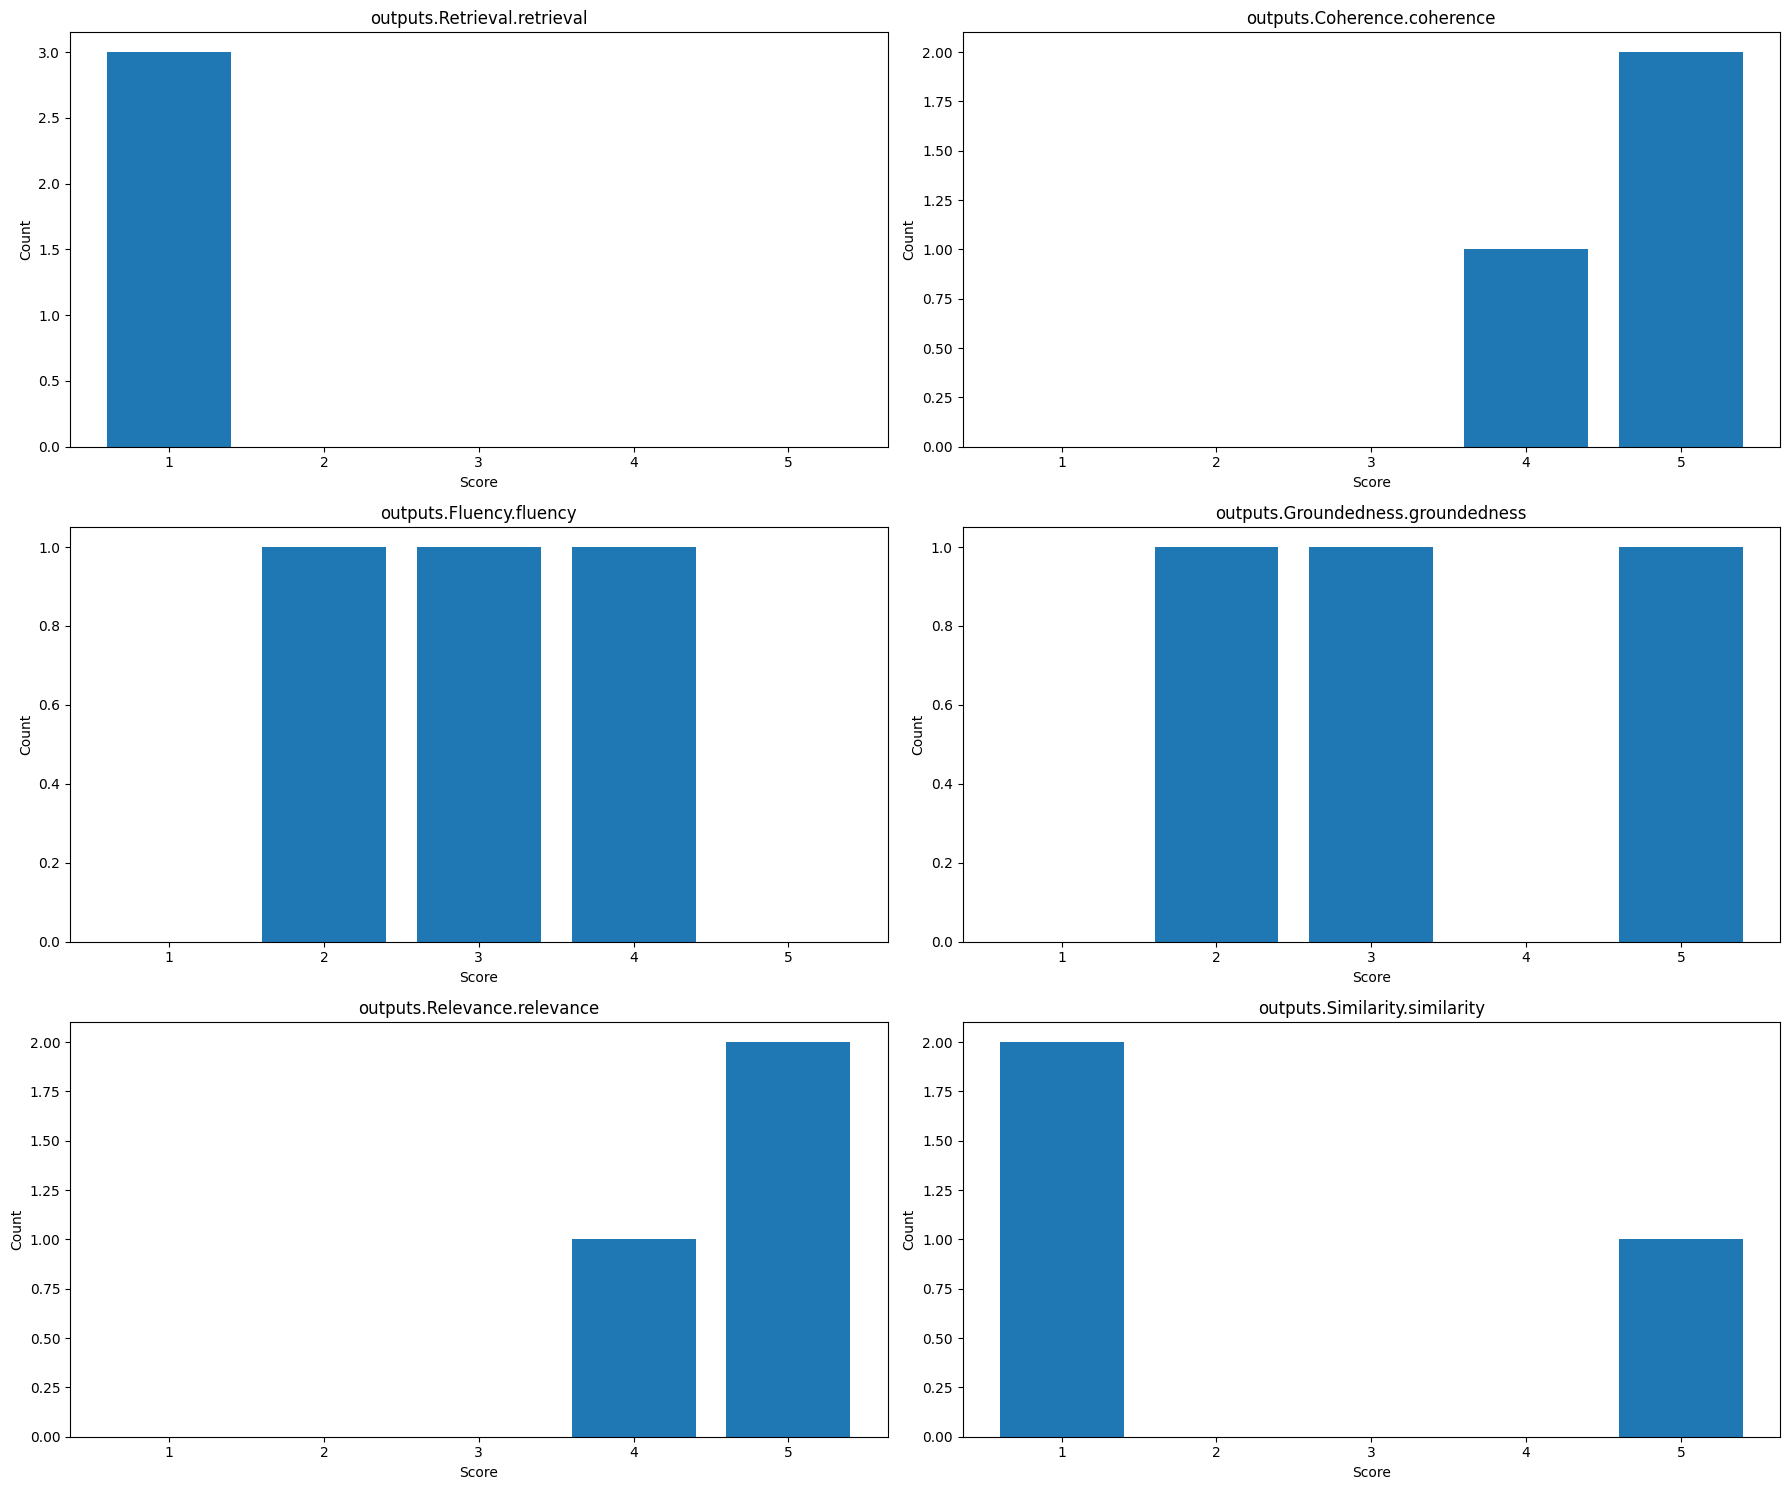

In [12]:
import json
import matplotlib.pyplot as plt
from collections import Counter

with open(output_path, "r", encoding="utf-8") as f:
    data = json.load(f)

rows = data["rows"]


rating_fields = [
    "outputs.Retrieval.retrieval",
    "outputs.Coherence.coherence",
    "outputs.Fluency.fluency",
    "outputs.Groundedness.groundedness",
    "outputs.Relevance.relevance",
    "outputs.Similarity.similarity",
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

for ax, field in zip(axes.flatten(), rating_fields):
    # count the occurrences of each score
    counter = Counter(row[field] for row in rows if field in row)
    
    
    x = [1, 2, 3, 4, 5]
    y = [counter.get(score, 0) for score in x]
    
    ax.bar(x, y)
    ax.set_title(field)
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()